# Time-resolved Optical Pumping and MW spin state manipulation

Operating at ~30 microW optical power.

Can see optical pumping time, similar to previous.

Very high RF power (-5 + 42 dbm) on resonance shows driving to a -1 state reaches
steady-state population within a single clock period of 10 microsecond. 

In order to time-resolve the RF pump to -1 (which is essentially looking for Rabi oscillations), would
need to decrease the clock resolution. Due to the programming issue of the pulse blaster, in order
to decrease the clock resolution, our entire pulse sequence needs to the be shorter. In order to do that
more optical power is needed in order to pump to the 0 state faster. In order to do that, need
to add ND filters to PL path so that SPCM is not saturated. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize
import copy
from scipy.optimize import leastsq
import scipy 

import logging


In [4]:
import qt3utils.experiments.ramsey
import qt3utils.experiments.cwodmr
import qt3utils.experiments.podmr
import qt3utils.experiments.rabi

from qt3utils.pulsers.pulseblaster import PulseBlasterRamHahnDD, PulseBlasterCWODMR, PulseBlasterPulsedODMR, PulseBlasterHoldAOM, PulseBlasterArb
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

import nipiezojenapy
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
import qt3utils.nidaq.config

In [12]:
import pickle
def save_file(name, data):
    with open(name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_file(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [7]:
logging.basicConfig(level=logging.WARNING)

In [152]:
qt3utils.experiments.cwodmr.logger.setLevel(logging.INFO)
datasources.daqsamplers.logger.setLevel(logging.INFO)

# Create objects to control hardware

In [9]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [14]:
aom_hold = PulseBlasterHoldAOM(pb_board_number=0)

In [73]:
aom_hold.program_pulser_state()
aom_hold.start() #do this to during confocal san
#if you get an error here, change the pb_board_number during instantiation of the object in cell above

<IPython.core.display.Javascript object>


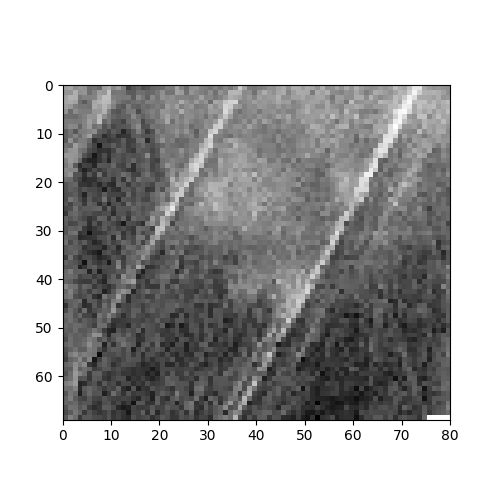

In [35]:
scan_file = 'large_scan_1micron_step_size.npy'
confocal_scan = np.load(scan_file)
plt.figure(figsize=(5,5))
plt.imshow(confocal_scan, cmap='Greys_r', extent = [0,confocal_scan.shape[1],confocal_scan.shape[0],0])

In [12]:
# NB - some sort of vertical artifact in scan. Saw it yesterday. Something related to the stage? 

In [146]:
def plot_contrast_scan(scan, xlabel = 'frequency [Hz]', figsize = (10,6), marker = '.-'):
    scan = np.array(scan)

    x_data = scan[:, 0]
    y_data = scan[:, 1]

    plt.figure(figsize=figsize)
    plt.plot(x_data, y_data, marker, label='Data')

    plt.xlabel(xlabel)

In [136]:
# Need to find RF resonance frequencies
cwodmr_pulser = PulseBlasterCWODMR(pb_board_number=0, clock_period = 10e-6)

In [137]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [138]:
cwodmr_exp = qt3utils.experiments.cwodmr.CWODMR(cwodmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-20)

In [139]:
cwodmr_pulser.rf_pulse_duration = 4e-3

In [140]:
cwodmr_exp.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -20,
 'pulser': {'rf_pulse_duration': 0.004, 'clock_period': 1e-05}}

In [154]:
cwodmr_exp.freq_low = 2700e6
cwodmr_exp.freq_high = 3000e6
cwodmr_exp.freq_step = 2e6
cwodmr_exp.rf_power = -10

In [155]:
scan_data = cwodmr_exp.run(N_cycles=50)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2700000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2702000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2704000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2706000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2708000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2710000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2712000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2714000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2716000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2718000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2720000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2722000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2724000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2726000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2728000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27300000

INFO:qt3utils.experiments.cwodmr:RF frequency: 2962000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2964000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2966000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2968000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2970000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2972000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2974000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2976000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2978000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2980000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2982000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2984000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2986000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2988000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2990000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29920000

<IPython.core.display.Javascript object>


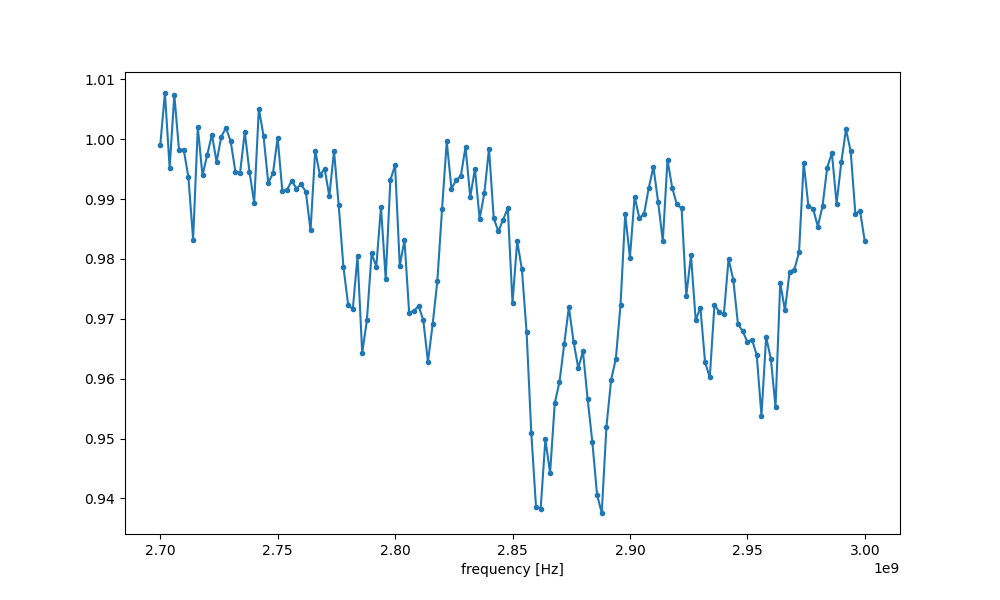

In [156]:
plot_contrast_scan(scan_data)

In [169]:
cwodmr_exp.freq_low = 2765e6
cwodmr_exp.freq_high = 2800e6
cwodmr_exp.freq_step = .5e6
cwodmr_exp.rf_power = -20

In [172]:
scan_data = cwodmr_exp.run(N_cycles=200)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2765000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2765500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2766000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2766500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2767000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2767500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2768000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2768500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2769000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2769500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2770000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2770500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2771000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2771500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2772000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27725000

<IPython.core.display.Javascript object>


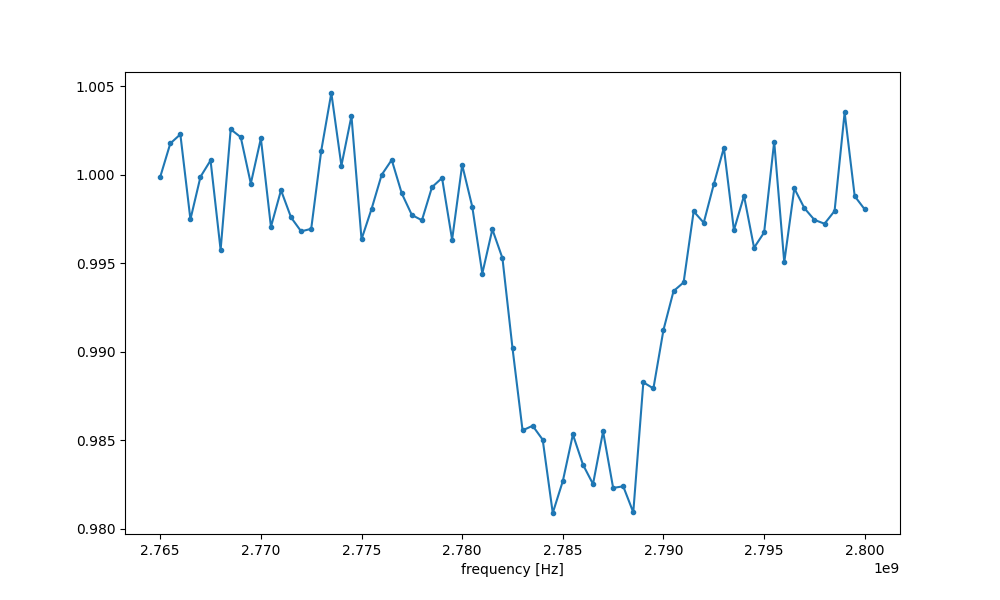

In [173]:
plot_contrast_scan(scan_data)

# Use Arbitrary pulse blaster object to create optical pump, followed by >> T1 time

In [158]:
arb_pulser = PulseBlasterArb(0)

In [159]:
arb_pulser.experimental_conditions()

{'full_cycle_width': 0,
 'clock_channels': [],
 'clock_period': None,
 'channel_settings': []}

In [160]:
arb_pulser.reset()
arb_pulser.add_channels([0,16], 500e-6, 6000e-6) #aom  #six millisecond
arb_pulser.add_channels([3,19], 0, 100e-6) #trigger
arb_pulser.add_channels([1,17], 2000e-6, 3000e-6) #RF, starts 1.5 milliseconds after, on for 3 milliseconds
arb_pulser.set_clock_channels([2,18], 10e-6)
arb_pulser.set_full_cycle_length(15000e-6) # 15 milliseconds should be long enough for ensemble to relax to boltzmann dist

In [161]:
arb_pulser.experimental_conditions()

{'full_cycle_width': 0.015,
 'clock_channels': [2, 18],
 'clock_period': 1e-05,
 'channel_settings': [{'channel': 0, 'start': 0.0005, 'width': 0.006},
  {'channel': 16, 'start': 0.0005, 'width': 0.006},
  {'channel': 3, 'start': 0, 'width': 0.0001},
  {'channel': 19, 'start': 0, 'width': 0.0001},
  {'channel': 1, 'start': 0.002, 'width': 0.003},
  {'channel': 17, 'start': 0.002, 'width': 0.003}]}

In [175]:
N_clock_ticks_per_cycle = arb_pulser.program_pulser_state()

In [195]:
N_cycles = 4000

In [200]:
rfsynth.set_frequency(0,2786.5e6)
rfsynth.set_frequency(0,2862e6)
rfsynth.set_power(0,-5)
rfsynth.rf_on(0)

In [196]:
data_sampler = datasources.NiDaqDigitalInputRateCounter(clock_rate = np.round(1./arb_pulser.clock_period, 9), 
                                                       clock_terminal = 'PFI12', trigger_terminal = 'PFI1',
                                                       num_data_samples_per_batch = N_clock_ticks_per_cycle*N_cycles)

In [201]:
data_sampler.start()
data, num_samples = data_sampler._read_samples()
data_sampler.stop()

INFO:qt3utils.datagenerators.daqsamplers:starting counter task
INFO:qt3utils.datagenerators.daqsamplers:waiting for 66.000000 seconds for data acquisition.
INFO:qt3utils.datagenerators.daqsamplers:reading data
INFO:qt3utils.datagenerators.daqsamplers:returned 6000000 samples


In [204]:
summed_trace = data.reshape(N_cycles, N_clock_ticks_per_cycle).sum(axis=0)
summed_trace /= summed_trace[summed_trace > 0.97*summed_trace.max()].mean()

<IPython.core.display.Javascript object>


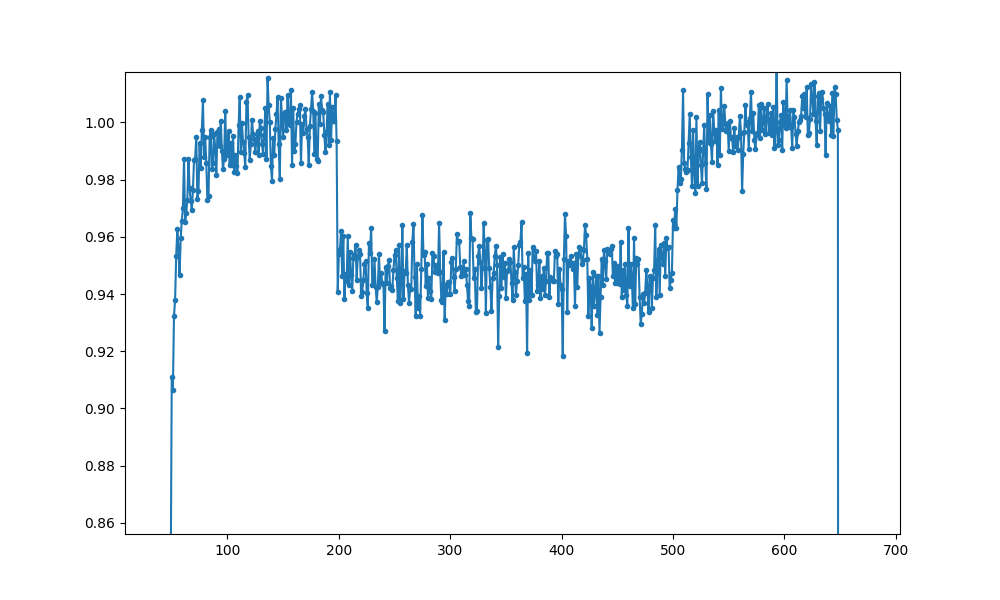

In [205]:
plt.figure(figsize=(10,6))
plt.plot(summed_trace, '.-')